# EDA - Walmart - preprocessing
> # index
### 1. 데이터 불러오기 및 함수 호출
### 2. 사전 데이터정제 및 garbage값 제거 (근거 간략요약)
    0) 3년기간동안 units가 모두 = 0 인 값 제거(존재하지않는 아이템값은 0이라고 가정한다)
    2) 데이터열 자료형 최적화
    3) 날씨코드구분
    4) 전체데이터 조합
    5) 날짜분할(년,월,일), 온도차, 컬럼생성
### 3. 데이터 column간 유사성/상관수준 비교
### 4. 병합
    1)  
    2)
    3)
### 5. 상세분석
### 6. likelihood함수의 변수삽입
    
### 부록 : 데이터 정제 근거자료

---
# 1. 데이터 불러오기 및 함수호출=========================



In [1]:
#주피터노트북 그래프설정

%matplotlib inline
#주피터노트북에서 라인 아래에 보여지도록 설정

%config InlineBackend.figure_formats = {'png','retina'} 
#png 이미지 압축기술설정, retina 그래프 해상도 2배 높히기

#그래프 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

#그래프 한글폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgunbd.ttf").get_name()
rc('font', family=font_name)
#음수처리
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import pandas_profiling as pdp

In [4]:
#전체기후날씨데이터(weather.csv) 불러오기--------------------------
weather = pd.read_csv('weather.csv')
# weather["date"]=weather["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
#지점-기후관측소 대조표(key.csv) 불러오기
map_key = pd.read_csv('key.csv')

#일일-지점-상품-판매량 정보(train.csv) 불러오기
store_data = pd.read_csv('train.csv')

#판매량 예측을 위한 지점정보(test.csv) 불러오기
test = pd.read_csv('test.csv')

In [5]:
# ★ 함수선언 ------------------------------------------------------
#-------날씨요소기준// 날짜-스테이션 데이터 도출함수
def weather_pivot(column_name):

    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])

        # 스테이션별 피봇팅(테이블)
    station_value = station_itm.pivot("date","station_nbr",column_name)
    station_table = station_value.apply(pd.to_numeric, errors = 'coerce')

    return station_table
    

#--------날씨요소기준// 날짜별 스테이션(숫자형)날씨요소 평균 도출함수---------
def weather_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["date","station_nbr",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M",None],np.NaN) #--특정문자 NaN으로 변환
    temp_df = temp_df.replace(["T","  T"],0.005)
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
    avg_df = avg_df.apply(pd.to_numeric, errors = 'ignore')

    return avg_df


#--------날씨요소기준// 스테이션-전체날짜 날씨요소평균 도출함수---------
def station_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M",None],np.NaN) #--특정문자 NaN으로 변환
    temp_df = temp_df.replace(["T","  T"],0.005)
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    station_avg = station_itm.pivot_table(column_name,["station_nbr"], aggfunc=np.mean)
    station_avg = station_avg.apply(pd.to_numeric, errors = 'ignore')
    
    return station_avg

#=============================================================================

#------★★완전체 형변환 함수(M,T,__T,None)==> 있는열도 변환 가능
def type_change_numeric(df, ls = []): 
    #ls에 있는 column name은 numeric형으로 바꾸지 않는다.
    cols = df.columns
    for i in cols:
        if i in ls:
            continue 
        df = df.replace(["M",None],np.NaN)
        df = df.replace(["T","  T"],0.005)
        df[i] = pd.to_numeric(df[i], errors='coerce')
        
    return df



In [6]:
#weather_p에 사전정제자료 삽입(codesum은 추가정제필요)
weather_p = type_change_numeric(weather,["station_nbr","codesum","date"])
weather_p["date"] = pd.to_datetime(weather_p["date"])

In [ ]:
weather_p.dtypes

---
# 2. 사전 데이터정제 및 Garbage값 제거===================

In [8]:
# 0) units = 0 인값 제거한 데이터프레임 만들기
store_df = store_data[store_data["units"]!=0]

In [9]:
# 1) 데이터 형변환(날짜 및 숫자)
import time

store_df["date"] = pd.to_datetime(store_df["date"])
weather["date"] = pd.to_datetime(weather["date"])

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [10]:
# 4) 전체데이터 조합 merge
#- 1. store_data에 스테이션 넘버 부여
result_df = store_df.merge(map_key, left_on="store_nbr", right_on="store_nbr" )
cols = ['date', 'store_nbr', 'station_nbr', 'item_nbr', 'units']
new_df = result_df[cols] #열 위치변경된 것들
#- 2. 종합세팅
all_set = new_df.merge(weather_p, left_on=["date","station_nbr"], right_on=["date","station_nbr"] )

In [11]:
# 데이터타입 날짜화 및 int화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
all_set["date"]=all_set["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
temp_df = type_change_numeric(all_set,["date","store_nbr","item_nbr","units","station_nbr","codesum"])

In [12]:
master = all_set.sort_values(["date","store_nbr","item_nbr"])

In [13]:
master['year'] = master['date'].dt.year
master['month'] = master['date'].dt.month
master['day'] = master['date'].dt.day
master['DOW']=master['date'].dt.dayofweek

---
# 3. 데이터 column간 유사성, 상관성 분석

In [72]:
#----------이제 특정 함수를 써보자!

#1. 이슬점온도
station_dewpoint = weather_pivot("dewpoint")
station_dewpoint_avg = weather_mean("dewpoint")

#2. 하루평균온도
station_temp = weather_pivot("tavg")
station_temp_avg = weather_mean("tavg")

#3. 하루평균 바람세기
station_speed = weather_pivot("avgspeed")
station_speed_avg = weather_mean("avgspeed")
station_speed_eachavg = station_mean("avgspeed")

#4. 기압도
station_pressure = weather_pivot("stnpressure")
station_pressure_avg = weather_mean("stnpressure")
station_pressure_eachavg = station_mean("stnpressure") #개별 스테이션별 평균 기압

#5. 이상기후온도
station_depart = weather_pivot("depart")
station_depart_avg = weather_mean("depart")

#6. 적셜량
station_snow = weather_pivot("snowfall")
station_snow_avg = weather_mean("snowfall")
station_snow_eachavg = station_mean("snowfall") #개별 스테이션별 평균 적설량

#7. 강우량
station_rain = weather_pivot("preciptotal")
station_rain_avg = weather_mean("preciptotal")
station_rain_eachavg = station_mean("preciptotal") #개별 스테이션별 평균 적설량

#8. 바람방향
station_dir = weather_pivot("resultdir")
station_dir_avg = weather_mean("resultdir")
station_dir_eachavg = station_mean("resultdir")
                           

### - 전체기준 X아이템넘버/Y판매갯수 추이 

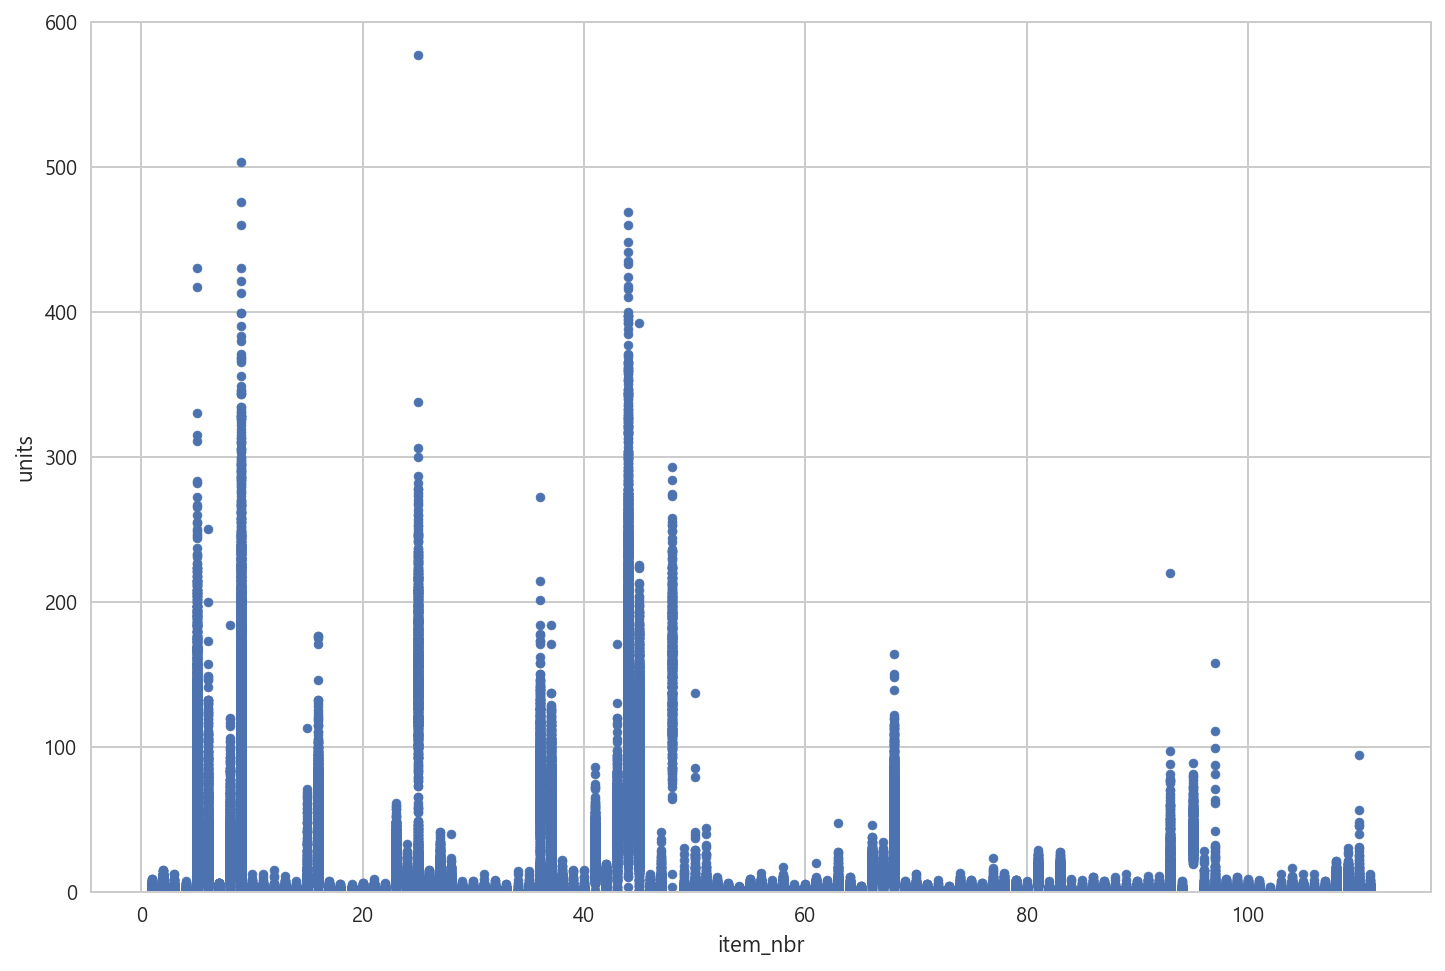

In [14]:
#각 아이템별 판매정도 추이
master.plot.scatter(x="item_nbr",y="units",figsize=(12,8),ylim=(0,600),style="hex")

### - 각 아이템기준 X날씨요소/Y판매량

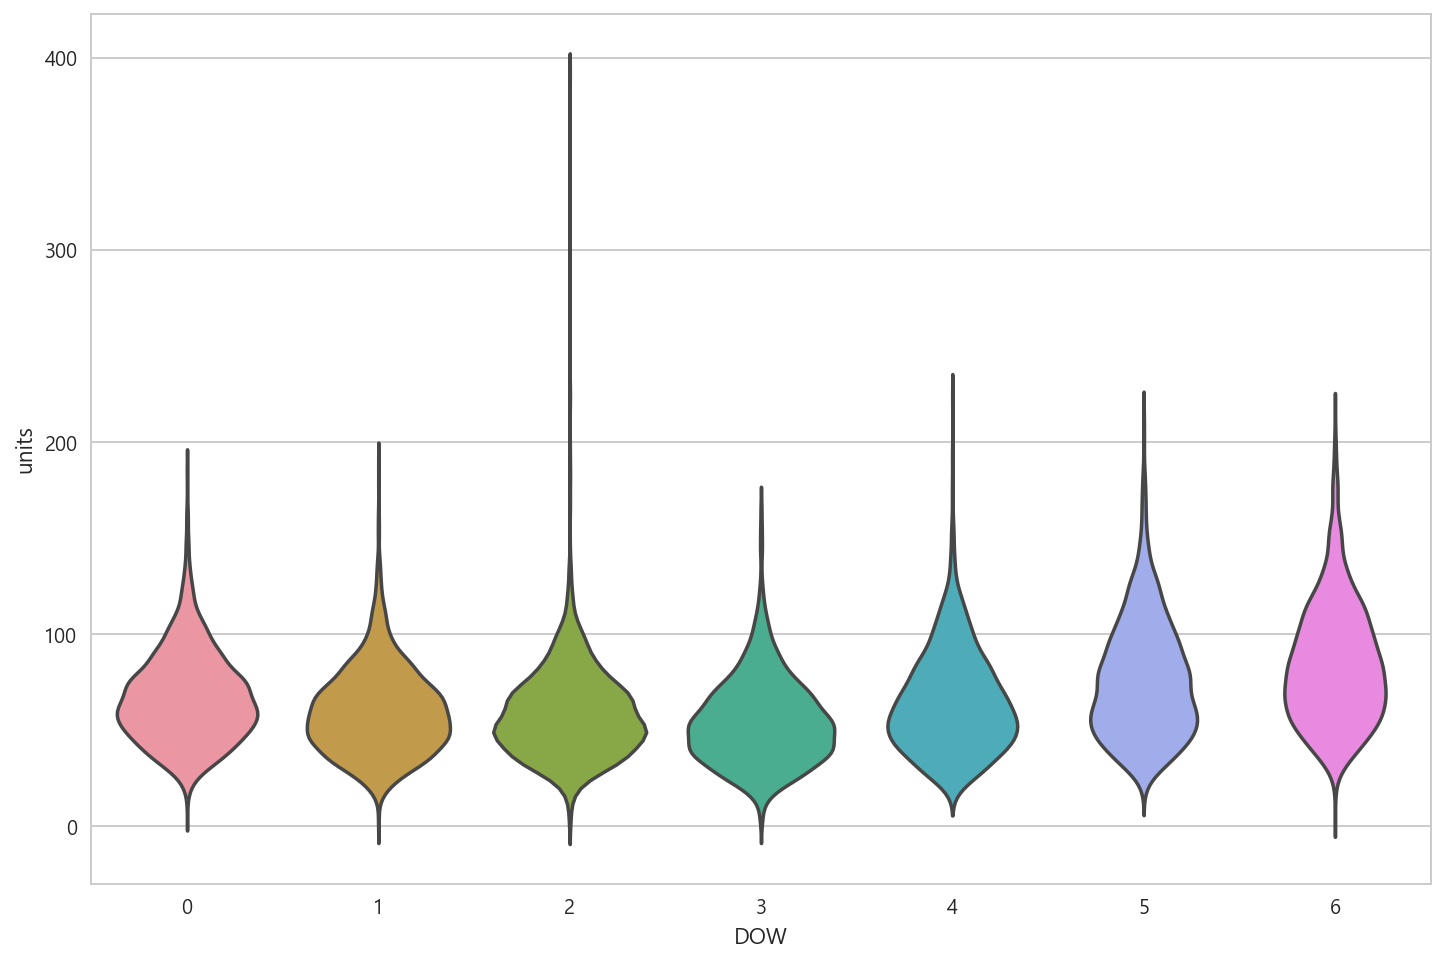

In [15]:
#대표적으로 2번아이템의 경우
item2 = master[master["item_nbr"]==45]
# item2.plot.scatter(x="preciptotal",y="units",figsize=(12,8))

fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(ax=ax, x="DOW", y="units", data=item2, inner=None)
# sns.swarmplot(ax=ax, x="DOW", y="units", data=item2, color="0.9")
plt.show()

In [71]:

count_code = master.groupby("codesum").size().reset_index(name="counts")
count_code.sort_values("counts", ascending=False).reset_index(drop=True)

,codesum,counts
0,,65560
1,BR,8079
2,RA,7982
3,RA BR,7522
4,BR HZ,2094
5,SN BR,1865
6,HZ,1859
7,TSRA RA BR,1415
8,TS,1411
9,TSRA,895


In [ ]:
#선형회귀분석툴 StatsModel임

dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])

model_boston2 = sm.OLS(dfy, dfX)
result_boston2 = model_boston2.fit()
print(result_boston2.summary())